# Notebook para gerar modelo que decide qual produto de financiamento do BNDES é o mais indicado para o cliente


**Objetivo**: O objetivo deste notebook é gerar um modelo que faz a predição de qual produto BNDES é mais adequado a um cliente de acordo com os dados. Para isso, o arquivo unificado "bndes_financiamentos.csv" gerado no notebook "BNDES - Normalizador de dataframes de financiamento" foi usado usado para treinar o modelo. O algoritmo utilizado é o Random Forest.


<img src="images/gerar_modelo_bndes.png">


A partir deles, iremos manipulá-los para ter apenas um arquivo final com os valores agrupados. O notebook está dividido nas seguintes etapas:
- 1. Lendo os arquivos csv gerado: leitura do csv bndes_financiamentos gerado no notebook "BNDES - Normalizador de dataframes de financiamento"
- 2. Fazendo análise exploratória: análise exploratória dos dados para entender melhor cada coluna
- 3. Filtrando: filtro de produtos
- 4. Treinando o modelo: treino de modelo usando o algoritmo random forest
- 5. Validando o modelo: validando os resultados do modelo. Modelo obteve mais de 0.9 de F1-score!
- 6. Salvando o modelo e encoder gerado: salvando o modelo treinado e a codificação das colunas categóricas

#### Sobre o modelo

Features usadas para identificar qual é o produto adequado:
- Natureza do cliente: natureza_do_cliente
- Porte do cliente: porte_do_cliente
- Valor a ser financiado: valor_contratado_reais
- Setor CNAE: setor_cnae
- Subsetor CNAE: subsetor_cnae
- Inovação: inovacao
- Ano de contratação: ano_contratado

Label:
- Produto: produto

### Importando os pacotes necessários

In [1]:
import os
import json
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report

### Pegando o path do arquivo gerado

In [2]:
dirname = os.getcwd()
csv_path = os.path.join(dirname, "csv")
models_path = os.path.join(dirname, "models")
result_dataframe_path = os.path.join(csv_path, "output_csv", "bndes_financiamentos.csv")

### Funções

In [20]:
def encode_categorical(column_lst):
    encoder = LabelEncoder().fit(column_lst)
    encoded_column = encoder.transform(column_lst)
    encoder_dict = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    return encoder_dict, encoded_column

def encode_label(df, label_column, training_encoder_dict):
    y_encoder_dict, y_encoded = encode_categorical(df[label_column])
    training_encoder_dict[label_column] = y_encoder_dict
    y = pd.Series(y_encoded)
    return y, training_encoder_dict
    
def encode_test_data(features_lst, training_encoder_dict, training_columns):
    test_data = []
    for feature, column in zip(features_lst, training_columns):
        encoded_feature_value = training_encoder_dict.get(column, {}).get(feature, None)
        if encoded_feature_value is None:
            test_data.append(feature)
        else:
            test_data.append(encoded_feature_value)
    return test_data

def encode_train_data(df, training_columns):
    training_encoder_dict = {}
    processed_columns_dict = {}
    for column in training_columns:
        if df[column].dtype == "O":
            encoder_dict, encoded_column = encode_categorical(df[column])
            training_encoder_dict[column] = encoder_dict
            processed_columns_dict[column] = encoded_column
        else:
            processed_columns_dict[column] = df[column].array
    X = pd.DataFrame(processed_columns_dict)
    return X, training_encoder_dict

def train_random_forest(df_x, df_y, label_dict, y_name):
    clf = RandomForestClassifier(random_state=1234, n_estimators=180, max_depth=13, criterion="gini")
    model = clf.fit(df_x, df_y)
    feature_importance_df = pd.DataFrame({"feature" : X.columns, "relevância da feature": model.feature_importances_})
    title = "Relevância das features na classificação de {}".format(y_name)
    ax = feature_importance_df.plot.bar(x="feature", y="relevância da feature", rot=90, title=title)
    return model

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)
    return X_train, X_test, y_train, y_test

def plot_offer_confusion_matrix(model, X_test, y_test, label_dict, title_text, cmap=plt.cm.Greens):
    text = "{} matriz de confusão".format(title_text)
    title_options = [(text, None),
                     (text, "true")]
    
    predicted = product_model.predict(X_test)
    labels = [key for key, value in encoder_dict["produto"].items() if value in set(predicted)]
    
    for title, normalize in title_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        confusion_matrix = plot_confusion_matrix(
            estimator=model, 
            X=X_test,
            y_true=y_test,
            cmap=cmap,
            normalize=normalize,
            xticks_rotation=90,
            ax=ax
        )
        confusion_matrix.ax_.set_title(title)

    plt.show()

def get_metrics(model, X_test, y_test, label_dict):
    y_pred = model.predict(X_test)
    labels = [key for key, value in label_dict.items() if value in set(y_pred)]
    print(classification_report(y_test, y_pred))
    f1_micro = f1_score(y_test, y_pred, average="micro")
    print("O F1 micro do modelo é {}".format(round(f1_micro, 3)))
    
def get_prediction(model, feature_data, encoder_dict, training_columns, label_column):
    encoded_test = encode_test_data(feature_data, encoder_dict, training_columns)
    encoded_prediction = model.predict([encoded_test])[0]
    prediction_prob = max(model.predict_proba([encoded_test])[0])
    decoder_dict = get_decoder_dict(encoder_dict[label_column])
    prediction = decoder_dict[encoded_prediction]
    return prediction, prediction_prob

def get_decoder_dict(encoder_dict):
    return {v: k for k, v in encoder_dict.items()}

def save_model(model, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(model, f)
    
def read_model(file_path):
    with open(file_path, "rb") as f:
        loaded_model = pickle.load(f)
    return loaded_model

def save_encoder(encoder, file_path):
    with open(file_path, "w") as f:
        json.dump(encoder, f)
    
def read_encoder(file_path):
    with open(file_path) as f:
        loaded_encoder = json.load(f)
    return loaded_encoder

### 1. Lendo o arquivo csv gerado

In [4]:
full_df = pd.read_csv(result_dataframe_path, encoding="utf-8", sep=";")
full_df

,cliente,custo_financeiro,data_da_contratacao,forma_de_apoio,inovacao,juros,natureza_do_cliente,porte_do_cliente,prazo_amortizacao_meses,prazo_carencia_meses,produto,setor_cnae,subsetor_cnae,valor_contratado_reais,ano_contratado
0,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,84,12,BNDES AUTOMÁTICO,COMERCIO E SERVICOS,ATIV AUX TRANSPORTE E ENTREGA,49958.0,2010
1,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,84,12,BNDES AUTOMÁTICO,COMERCIO E SERVICOS,ATIV AUX TRANSPORTE E ENTREGA,103612.0,2010
2,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,5.75,PRIVADA,MICRO,36,24,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,200000.0,2010
3,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,5.75,PRIVADA,MICRO,60,0,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,100172.0,2010
4,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,48,96,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,200000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256977,DURATEX S.A.,TAXA FIXA,07/02/2013,DIRETA,SIM,3.50,PRIVADA,GRANDE,60,24,BNDES LIMITE DE CRÉDITO,INDUSTRIA DE TRANSFORMAÇÃO,MINERAL NÃO METÁLICO,3938120.0,2013
1256978,DURATEX S.A.,TJLP,13/11/2012,DIRETA,NÃO,2.16,PRIVADA,GRANDE,60,12,BNDES LIMITE DE CRÉDITO,INDUSTRIA DE TRANSFORMAÇÃO,MADEIRA,76512000.0,2012
1256979,CAMERA AGROINDUSTRIAL S.A.,TJLP,18/07/2012,DIRETA,NÃO,3.84,PRIVADA,GRANDE,96,12,BNDES FINEM,INDUSTRIA DE TRANSFORMAÇÃO,PRODUTOS ALIMENTÍCIOS,33749000.0,2012
1256980,COOPERATIVA MISTA SAO LUIZ LTDA.,TAXA FIXA,04/12/2013,INDIRETA,NÃO,5.50,PRIVADA,GRANDE,96,24,BNDES FINEM,COMERCIO E SERVICOS,COMÉRCIO,16803817.0,2013


### 2. Fazendo análise exploratória dos dados

In [5]:
full_df.columns

Index(['cliente', 'custo_financeiro', 'data_da_contratacao', 'forma_de_apoio',
       'inovacao', 'juros', 'natureza_do_cliente', 'porte_do_cliente',
       'prazo_amortizacao_meses', 'prazo_carencia_meses', 'produto',
       'setor_cnae', 'subsetor_cnae', 'valor_contratado_reais',
       'ano_contratado'],
      dtype='object')

In [6]:
full_df["setor_cnae"].value_counts()

COMERCIO E SERVICOS           981041
INDUSTRIA DE TRANSFORMAÇÃO    215044
AGROPECUÁRIA E PESCA           50234
INDUSTRIA EXTRATIVA            10663
Name: setor_cnae, dtype: int64

In [7]:
full_df["subsetor_cnae"].value_counts()

TRANSPORTE TERRESTRE               508881
COMÉRCIO                           269369
CONSTRUÇÃO                          77826
PRODUTOS ALIMENTÍCIOS               55049
ATIV IMOBIL, PROFISSIONAL E ADM     51970
AGROPECUÁRIA                        50234
MINERAL NÃO METÁLICO                21412
BORRACHA E PLÁSTICO                 16243
PRODUTO DE METAL                    15749
ATIV AUX TRANSPORTE E ENTREGA       13517
MÁQUINAS E EQUIPAMENTOS             12326
MÓVEIS                              11025
ALOJAMENTO E ALIMENTAÇÃO            10926
ÁGUA, ESGOTO E LIXO                 10849
INDÚSTRIA EXTRATIVA                 10663
ATIV FINANCEIRA E SEGURO            10103
QUÍMICA                              9867
CONFEC, VESTUÁRIO E ACESSÓRIOS       9362
MADEIRA                              9046
COQUE, PETRÓLEO E COMBUSTÍVEL        6827
SAÚDE E SERV SOCIAL                  6273
VEÍCULO, REBOQUE E CARROCERIA        5540
TÊXTIL                               5516
BEBIDAS                           

In [8]:
full_df["produto"].value_counts()

BNDES FINAME                                         1048069
BNDES AUTOMÁTICO                                      192445
BNDES FINAME AGRÍCOLA                                   6754
BNDES FINAME LEASING                                    4386
BNDES FINEM                                             3340
BNDES PROJECT FINANCE                                    635
BNDES NÃO REEMBOLSÁVEL                                   627
BNDES LIMITE DE CRÉDITO                                  294
BNDES DEBENTURES SIMPLES                                 167
BNDES EMPRÉSTIMO PONTE                                   140
BNDES MICROCRÉDITO                                        64
OPERAÇÃO FINANCEIRA                                       40
BNDES DIRETO 10                                           12
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS                       6
BNDES RENEGOCIAÇÃO                                         1
BNDES EXIM PÓS-EMBARQUE                                    1
BNDES DEBENTURES SUSTENT

In [9]:
pd.DataFrame(full_df.groupby(["produto"]).natureza_do_cliente.unique())

,natureza_do_cliente
produto,
BNDES AUTOMÁTICO,"[PRIVADA, ADMINISTRAÇÃO PÚBLICA DIRETA - GOVER..."
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[PRIVADA]
BNDES DEBENTURES SIMPLES,"[PRIVADA, PÚBLICA INDIRETA]"
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[PRIVADA]
BNDES DIRETO 10,[PRIVADA]
BNDES EMPRÉSTIMO PONTE,"[PRIVADA, PÚBLICA INDIRETA]"
BNDES EXIM PÓS-EMBARQUE,[PÚBLICA INDIRETA]
BNDES FINAME,"[PRIVADA, ADMINISTRAÇÃO PÚBLICA DIRETA - GOVER..."
BNDES FINAME AGRÍCOLA,[PRIVADA]


In [10]:
pd.DataFrame(full_df.groupby(["produto"]).porte_do_cliente.unique())

,porte_do_cliente
produto,
BNDES AUTOMÁTICO,"[MICRO, PEQUENA, MÉDIA, GRANDE]"
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,"[MÉDIA, GRANDE]"
BNDES DEBENTURES SIMPLES,"[GRANDE, MÉDIA]"
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[GRANDE]
BNDES DIRETO 10,[MÉDIA]
BNDES EMPRÉSTIMO PONTE,"[GRANDE, MÉDIA, MICRO]"
BNDES EXIM PÓS-EMBARQUE,[GRANDE]
BNDES FINAME,"[GRANDE, MÉDIA, PEQUENA, MICRO]"
BNDES FINAME AGRÍCOLA,"[MICRO, MÉDIA, PEQUENA, GRANDE]"


In [11]:
pd.DataFrame(full_df.groupby(["produto", "setor_cnae"]).subsetor_cnae.unique())

subsetor_cnae
produto                                           setor_cnae                                                                   
BNDES AUTOMÁTICO                                  AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, COMÉRCIO, ARTE...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [BEBIDAS, QUÍMICA, PRODUTOS ALIMENTÍCIOS, MINE...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS              COMERCIO E SERVICOS                      [COMÉRCIO, ALOJAMENTO E ALIMENTAÇÃO]
                                                  INDUSTRIA DE TRANSFORMAÇÃO     [BORRACHA E PLÁSTICO, MÁQUINAS E EQUIPAMENTOS]
BNDES DEBENTURES SIMPLES                          COMERCIO E SERVICOS         [ELETRICIDADE E GÁS, ATIV FINANCEIRA E SEGURO,...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [PRODUTOS ALIMENTÍCIOS, COQUE, PETRÓLEO E COMB...
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA COMERCIO E SERVICOS                           [ATIV AUX TRANSPORTE E ENTREGA]
BNDES DIRETO 10                                   COMERCIO E SERVICOS         [INFORMAÇÃO E COMUNICAÇÃO, ELETRICIDADE E GÁS,...
                                                  INDUSTRIA DE TRANSFORMAÇÃO                              [BORRACHA E PLÁSTICO]
BNDES EMPRÉSTIMO PONTE                            COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, TRANSPORTE TER...
BNDES EXIM PÓS-EMBARQUE                           INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINAME                                      AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [COMÉRCIO, TRANSPORTE TERRESTRE, ARTES, CULTUR...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [MADEIRA, CELULOSE E PAPEL, PRODUTOS ALIMENTÍC...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINAME AGRÍCOLA                             AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ATIV AUX TRANSPORTE E ENTREGA, ATIV IMOBIL, P...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [PRODUTOS ALIMENTÍCIOS, TÊXTIL, QUÍMICA, COQUE...
BNDES FINAME LEASING                              AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [TRANSPORTE TERRESTRE, COMÉRCIO, CONSTRUÇÃO, I...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [PRODUTOS ALIMENTÍCIOS, CELULOSE E PAPEL, EQUI...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES FINEM                                       AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [ADMINISTRAÇÃO PÚBLICA, ELETRICIDADE E GÁS, ÁG...
                                                  INDUSTRIA DE TRANSFORMAÇÃO  [QUÍMICA, PRODUTOS ALIMENTÍCIOS, BORRACHA E PL...
                                                  INDUSTRIA EXTRATIVA                                     [INDÚSTRIA EXTRATIVA]
BNDES LIMITE DE CRÉDITO                           AGROPECUÁRIA E PESCA                                           [AGROPECUÁRIA]
                                                  COMERCIO E SERVICOS         [COMÉRCIO, TRANSPORTE TERRESTRE, ELETRICIDADE ...
                  

In [12]:
pd.DataFrame(full_df.groupby(["produto"]).inovacao.unique())

,inovacao
produto,
BNDES AUTOMÁTICO,"[NÃO, SIM]"
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,[NÃO]
BNDES DEBENTURES SIMPLES,[NÃO]
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[NÃO]
BNDES DIRETO 10,"[NÃO, SIM]"
BNDES EMPRÉSTIMO PONTE,[NÃO]
BNDES EXIM PÓS-EMBARQUE,[NÃO]
BNDES FINAME,"[NÃO, SIM]"
BNDES FINAME AGRÍCOLA,"[NÃO, SIM]"


In [13]:
pd.DataFrame(full_df.groupby(["produto"]).ano_contratado.unique())

,ano_contratado
produto,
BNDES AUTOMÁTICO,"[2010, 2020, 2019, 2021, 2017, 2012, 2013, 201..."
BNDES CRÉDITO DIRETO MÉDIAS EMPRESAS,"[2019, 2020]"
BNDES DEBENTURES SIMPLES,"[2013, 2015, 2012, 2010, 2018, 2021, 2011, 201..."
BNDES DEBENTURES SUSTENTAVEIS E DE INFRAESTRUTURA,[2021]
BNDES DIRETO 10,[2020]
BNDES EMPRÉSTIMO PONTE,"[2015, 2012, 2014, 2010, 2011, 2013, 2016, 2019]"
BNDES EXIM PÓS-EMBARQUE,[2013]
BNDES FINAME,"[2016, 2017, 2010, 2011, 2012, 2013, 2014, 201..."
BNDES FINAME AGRÍCOLA,"[2010, 2016, 2011, 2012, 2013, 2015, 2017, 2014]"


### 3. Filtrando 

In [14]:
count_min = 20
full_df = full_df[full_df.groupby("produto").produto.transform("count")> 20].copy() 
full_df

,cliente,custo_financeiro,data_da_contratacao,forma_de_apoio,inovacao,juros,natureza_do_cliente,porte_do_cliente,prazo_amortizacao_meses,prazo_carencia_meses,produto,setor_cnae,subsetor_cnae,valor_contratado_reais,ano_contratado
0,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,84,12,BNDES AUTOMÁTICO,COMERCIO E SERVICOS,ATIV AUX TRANSPORTE E ENTREGA,49958.0,2010
1,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,84,12,BNDES AUTOMÁTICO,COMERCIO E SERVICOS,ATIV AUX TRANSPORTE E ENTREGA,103612.0,2010
2,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,5.75,PRIVADA,MICRO,36,24,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,200000.0,2010
3,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,5.75,PRIVADA,MICRO,60,0,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,100172.0,2010
4,BANCO DO BRASIL SA,TAXA FIXA,04/01/2010,INDIRETA,NÃO,6.75,PRIVADA,MICRO,48,96,BNDES AUTOMÁTICO,AGROPECUÁRIA E PESCA,AGROPECUÁRIA,200000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256977,DURATEX S.A.,TAXA FIXA,07/02/2013,DIRETA,SIM,3.50,PRIVADA,GRANDE,60,24,BNDES LIMITE DE CRÉDITO,INDUSTRIA DE TRANSFORMAÇÃO,MINERAL NÃO METÁLICO,3938120.0,2013
1256978,DURATEX S.A.,TJLP,13/11/2012,DIRETA,NÃO,2.16,PRIVADA,GRANDE,60,12,BNDES LIMITE DE CRÉDITO,INDUSTRIA DE TRANSFORMAÇÃO,MADEIRA,76512000.0,2012
1256979,CAMERA AGROINDUSTRIAL S.A.,TJLP,18/07/2012,DIRETA,NÃO,3.84,PRIVADA,GRANDE,96,12,BNDES FINEM,INDUSTRIA DE TRANSFORMAÇÃO,PRODUTOS ALIMENTÍCIOS,33749000.0,2012
1256980,COOPERATIVA MISTA SAO LUIZ LTDA.,TAXA FIXA,04/12/2013,INDIRETA,NÃO,5.50,PRIVADA,GRANDE,96,24,BNDES FINEM,COMERCIO E SERVICOS,COMÉRCIO,16803817.0,2013


### 4. Treinando o modelo

In [15]:
training_columns = ["natureza_do_cliente", "porte_do_cliente", "valor_contratado_reais", "setor_cnae", "subsetor_cnae", "inovacao", "ano_contratado"]
X, encoder_dict = encode_train_data(full_df, training_columns)
X

,natureza_do_cliente,porte_do_cliente,valor_contratado_reais,setor_cnae,subsetor_cnae,inovacao,ano_contratado
0,3,1,49958.0,1,4,0,2010
1,3,1,103612.0,1,4,0,2010
2,3,1,200000.0,0,1,0,2010
3,3,1,100172.0,0,1,0,2010
4,3,1,200000.0,0,1,0,2010
...,...,...,...,...,...,...,...
1256956,3,0,3938120.0,2,26,1,2013
1256957,3,0,76512000.0,2,23,0,2012
1256958,3,0,33749000.0,2,34,0,2012
1256959,3,0,16803817.0,1,10,0,2013


RandomForestClassifier(max_depth=13, n_estimators=180, random_state=1234)

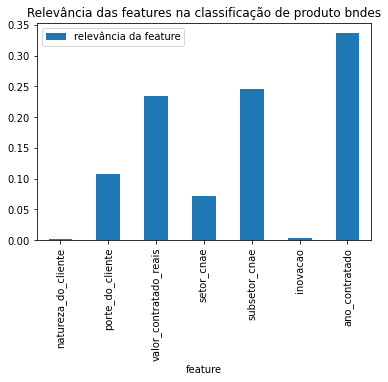

In [16]:
y_product, encoder_dict = encode_label(full_df, "produto", encoder_dict)
X_train, X_test, y_product_train, y_product_test = split_data(X, y_product)
product_model = train_random_forest(X_train, y_product_train, encoder_dict, y_name="produto bndes")
product_model

### 5. Validando o modelo

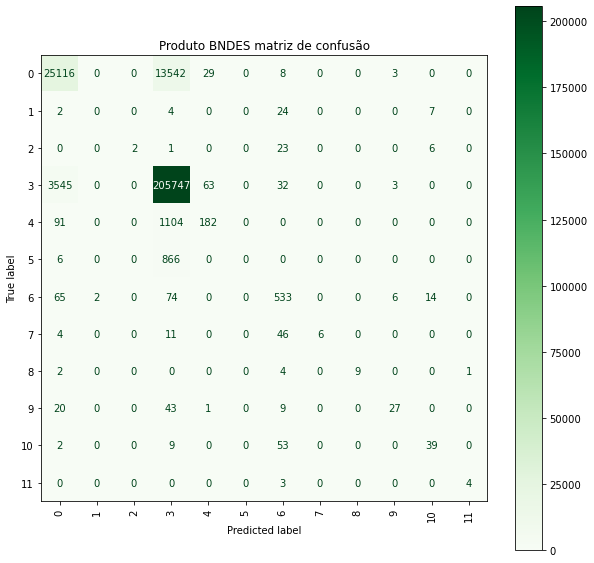

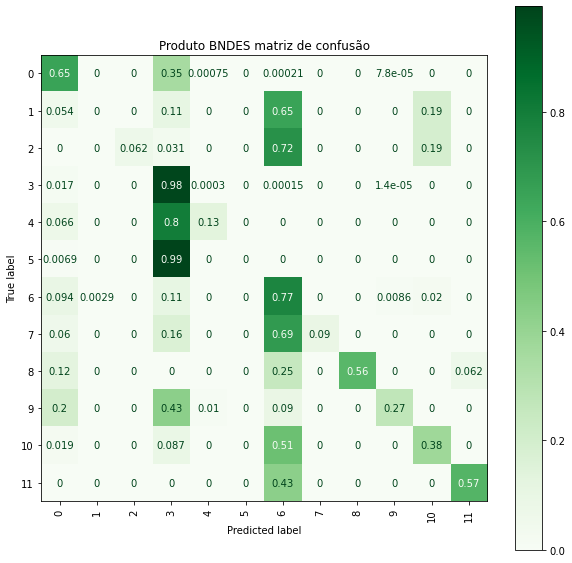

              precision    recall  f1-score   support

           0       0.87      0.65      0.74     38698
           1       0.00      0.00      0.00        37
           2       1.00      0.06      0.12        32
           3       0.93      0.98      0.96    209390
           4       0.66      0.13      0.22      1377
           5       0.00      0.00      0.00       872
           6       0.73      0.77      0.75       694
           7       1.00      0.09      0.16        67
           8       1.00      0.56      0.72        16
           9       0.69      0.27      0.39       100
          10       0.59      0.38      0.46       103
          11       0.80      0.57      0.67         7

    accuracy                           0.92    251393
   macro avg       0.69      0.37      0.43    251393
weighted avg       0.91      0.92      0.91    251393

O F1 micro do modelo é 0.922


C:\Users\karina.kato_ifood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karina.kato_ifood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karina.kato_ifood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
plot_offer_confusion_matrix(product_model, X_test, y_product_test, encoder_dict["produto"], "Produto BNDES")
get_metrics(product_model, X_test, y_product_test, encoder_dict["produto"])

In [22]:
training_columns

['natureza_do_cliente',
 'porte_do_cliente',
 'valor_contratado_reais',
 'setor_cnae',
 'subsetor_cnae',
 'inovacao',
 'ano_contratado']

In [23]:
encoder_dict["produto"]

{'BNDES AUTOMÁTICO': 0,
 'BNDES DEBENTURES SIMPLES': 1,
 'BNDES EMPRÉSTIMO PONTE': 2,
 'BNDES FINAME': 3,
 'BNDES FINAME AGRÍCOLA': 4,
 'BNDES FINAME LEASING': 5,
 'BNDES FINEM': 6,
 'BNDES LIMITE DE CRÉDITO': 7,
 'BNDES MICROCRÉDITO': 8,
 'BNDES NÃO REEMBOLSÁVEL': 9,
 'BNDES PROJECT FINANCE': 10,
 'OPERAÇÃO FINANCEIRA': 11}

In [24]:
feature_data = ["PRIVADA", "MICRO", 400000, "COMERCIO E SERVICOS", "COMÉRCIO", 1, 2021]
encoded_test = encode_test_data(feature_data, encoder_dict, training_columns)
product_model.predict([encoded_test])[0]

0

In [25]:
full_df[full_df["produto"] == 'BNDES FINEM'].natureza_do_cliente.value_counts()

PRIVADA                                             3007
PÚBLICA INDIRETA                                     138
ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL      112
ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO MUNICIPAL      83
Name: natureza_do_cliente, dtype: int64

In [26]:
full_df[full_df["produto"] == 'BNDES FINEM'].porte_do_cliente.value_counts()

GRANDE     2828
MÉDIA       351
PEQUENA     108
MICRO        53
Name: porte_do_cliente, dtype: int64

In [27]:
feature_data = ["PRIVADA", "MICRO", 400000, "COMERCIO E SERVICOS", "COMÉRCIO", 1, 2021]
get_prediction(product_model, feature_data, encoder_dict, training_columns, "produto")

('BNDES AUTOMÁTICO', 0.5295370951275273)

### 6. Salvando o modelo e encoder gerado

In [28]:
product_model_path = os.path.join(models_path, "modelo_produto.pkl")
encoder_path = os.path.join(models_path, "encoder.json")
save_model(product_model, product_model_path)
model_test = read_model(product_model_path)
get_prediction(model_test, feature_data, encoder_dict, training_columns, "produto")
save_encoder(encoder_dict, encoder_path)
read_encoder(encoder_path)

{'natureza_do_cliente': {'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO ESTADUAL': 0,
  'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO FEDERAL': 1,
  'ADMINISTRAÇÃO PÚBLICA DIRETA - GOVERNO MUNICIPAL': 2,
  'PRIVADA': 3,
  'PÚBLICA INDIRETA': 4},
 'porte_do_cliente': {'GRANDE': 0, 'MICRO': 1, 'MÉDIA': 2, 'PEQUENA': 3},
 'setor_cnae': {'AGROPECUÁRIA E PESCA': 0,
  'COMERCIO E SERVICOS': 1,
  'INDUSTRIA DE TRANSFORMAÇÃO': 2,
  'INDUSTRIA EXTRATIVA': 3},
 'subsetor_cnae': {'ADMINISTRAÇÃO PÚBLICA': 0,
  'AGROPECUÁRIA': 1,
  'ALOJAMENTO E ALIMENTAÇÃO': 2,
  'ARTES, CULTURA E ESPORTE': 3,
  'ATIV AUX TRANSPORTE E ENTREGA': 4,
  'ATIV FINANCEIRA E SEGURO': 5,
  'ATIV IMOBIL, PROFISSIONAL E ADM': 6,
  'BEBIDAS': 7,
  'BORRACHA E PLÁSTICO': 8,
  'CELULOSE E PAPEL': 9,
  'COMÉRCIO': 10,
  'CONFEC, VESTUÁRIO E ACESSÓRIOS': 11,
  'CONSTRUÇÃO': 12,
  'COQUE, PETRÓLEO E COMBUSTÍVEL': 13,
  'COURO, ARTEFATO E CALÇADO': 14,
  'EDUCAÇÃO': 15,
  'ELETRICIDADE E GÁS': 16,
  'EQUIP INFO, ELETRONICO, ÓTICO': 17,
  'FARM

In [29]:
full_df.custo_financeiro.value_counts()

TAXA FIXA       785983
TJLP            215747
TJ462           132129
TLP              72337
SELIC            44671
US$ / CESTA       3437
TJ453             1546
SEM CUSTO          629
75% da SELIC       230
IPCA               150
CDI                 38
90% da SELIC        27
OUTROS              16
TJ6                 16
108% do CDI          2
FAN                  2
TJ3                  1
Name: custo_financeiro, dtype: int64